<a href="https://colab.research.google.com/github/Arshpreet-Singh-1/Poetry-Generator-Using-NLP/blob/main/Poetry_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/irish-lyrics-eof.txt \
    -O /tmp/irish-lyrics-eof.txt

--2022-03-14 04:54:35--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/irish-lyrics-eof.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.121.128, 108.177.120.128, 142.250.128.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.121.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68970 (67K) [text/plain]
Saving to: ‘/tmp/irish-lyrics-eof.txt’

/tmp/irish-lyrics-e 100%[===================>]  67.35K  --.-KB/s    in 0.001s  

2022-03-14 04:54:36 (87.6 MB/s) - ‘/tmp/irish-lyrics-eof.txt’ saved [68970/68970]



#Getting Started with Tokenization

TensorFlow Keras contains a library called preprocessing that provides a number of
extremely useful tools to prepare data for machine learning. One of these is a
Tokenizer that will allow you to take words and turn them into tokens

In this case, we create a Tokenizer object and Once we have a tokenizer, calling fit_on_texts will create the tokenized word index.
Printing this out will show a set of key/value pairs for the words in the corpus, like
this:


In [3]:
tokenizer = Tokenizer()

data = open('/tmp/irish-lyrics-eof.txt').read()

corpus = data.lower().split("\n")

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

print(tokenizer.word_index)
print(total_words)

{'the': 1, 'and': 2, 'i': 3, 'to': 4, 'a': 5, 'of': 6, 'my': 7, 'in': 8, 'me': 9, 'for': 10, 'you': 11, 'all': 12, 'was': 13, 'she': 14, 'that': 15, 'on': 16, 'with': 17, 'her': 18, 'but': 19, 'as': 20, 'when': 21, 'love': 22, 'is': 23, 'your': 24, 'it': 25, 'will': 26, 'from': 27, 'by': 28, 'they': 29, 'be': 30, 'are': 31, 'so': 32, 'he': 33, 'old': 34, 'no': 35, 'oh': 36, 'ill': 37, 'at': 38, 'one': 39, 'his': 40, 'there': 41, 'were': 42, 'heart': 43, 'down': 44, 'now': 45, 'we': 46, 'where': 47, 'young': 48, 'never': 49, 'go': 50, 'come': 51, 'then': 52, 'did': 53, 'not': 54, 'said': 55, 'away': 56, 'their': 57, 'sweet': 58, 'them': 59, 'green': 60, 'if': 61, 'take': 62, 'our': 63, 'like': 64, 'night': 65, 'day': 66, 'o': 67, 'out': 68, 'fair': 69, 'this': 70, 'town': 71, 'have': 72, 'can': 73, 'true': 74, 'its': 75, 'thou': 76, 'see': 77, 'dear': 78, 'more': 79, 'theres': 80, 'or': 81, 'had': 82, 'would': 83, 'over': 84, 'hear': 85, 'up': 86, 'ive': 87, 'through': 88, 'home': 89, '

# Turning Sequences into Input Sequencess

Now that you’ve seen how to take words and tokenize them into numbers, the next
step is to encode the sentences into sequences of numbers. The tokenizer has a
method for this called text_to_sequences—all you have to do is pass it your list of
sentences, and it will give you back a list of sequences.

But When predicting text, you need to train a neural network with an input sequence
(feature) that has an associated label. Matching sequences to labels is the key to pre‐
dicting text.

To do this you’ll need to go through each line in the corpus and turn it into a list of
tokens using texts_to_sequences. Then you can split each list by looping through
each token and making a list of all the tokens up to it.

In [4]:
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

Once you have these input sequences, you can pad them into a regular shape. We’ll
use prepadding.

To do this, you’ll need to find the longest sentence in the input sequences, and pad
everything to that length

In [5]:
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

Finally, once you have a set of padded input sequences, you can split these into features and labels, where the label is simply the last token in the input sequence

In [6]:
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

Next, you need to encode the label. To encode your labels into a set of Ys that you can then use to train, you can use the
to_categorical utility in tf.keras:

In [7]:
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

# Creating the Model

Let’s now create a simple model that can be trained with this input data. It will consist of just an embedding layer, followed by two LSTM, followed by a dense layer.

For the embedding you’ll need one vector per word, so the parameters will be the
total number of words and the number of dimensions you want to embed on. 

You can make the LSTM bidirectional, and the number of steps can be the length of a sequence, which is our max length minus 1 (because we took one token off the end to make the label). We are using multiple
stacked LSTMs. This is pretty straightforward—just ensure that you set
return_sequences to True on the first of them.

Finally, the output layer will be a dense layer with the total number of words as a parameter, activated by softmax. Each neuron in this layer will be the probability that the next word matches the word for that index value:

Compile the model with a categorical loss function such as categorical cross entropy and an optimizer like Adam. You can also specify that you want to capture metrics.

In [8]:
model = Sequential()
model.add(Embedding(total_words, 8))
model.add(Bidirectional(LSTM(max_sequence_len-1, return_sequences='True')))
model.add(Bidirectional(LSTM(max_sequence_len-1)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(xs, ys, epochs=10, verbose=1)

Epoch 1/10
377/377 [==============================] - 21s 22ms/step - loss: 6.8550 - accuracy: 0.0652
Epoch 2/10
377/377 [==============================] - 8s 22ms/step - loss: 6.3941 - accuracy: 0.0657
Epoch 3/10
377/377 [==============================] - 9s 23ms/step - loss: 6.2822 - accuracy: 0.0656
Epoch 4/10
377/377 [==============================] - 8s 22ms/step - loss: 6.2019 - accuracy: 0.0674
Epoch 5/10
377/377 [==============================] - 8s 22ms/step - loss: 6.1262 - accuracy: 0.0712
Epoch 6/10
377/377 [==============================] - 8s 21ms/step - loss: 6.0520 - accuracy: 0.0741
Epoch 7/10
377/377 [==============================] - 8s 22ms/step - loss: 5.9876 - accuracy: 0.0763
Epoch 8/10
377/377 [==============================] - 8s 22ms/step - loss: 5.9310 - accuracy: 0.0796
Epoch 9/10
377/377 [==============================] - 8s 22ms/step - loss: 5.8814 - accuracy: 0.0814
Epoch 10/10
377/377 [==============================] - 9s 23ms/step - loss: 5.8352 - accur

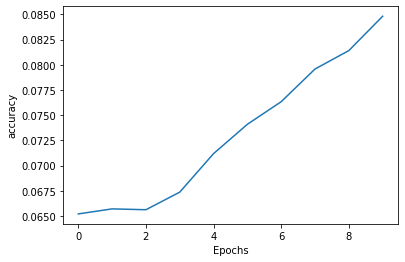

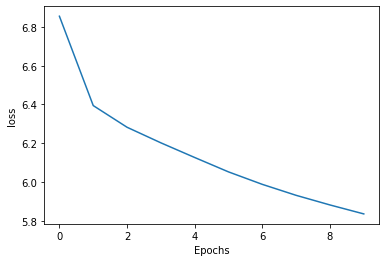

In [9]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

# Generating Text
Now that you’ve trained a network that can predict the next word in a sequence, the
next step is to give it a sequence of text and have it predict the next word. Let’s take a
look at how to do that

# Predicting the Next Word
You’ll start by creating a phrase called the seed text. This is the initial expression on which the network will base all the content it generates. It will do this by predicting the next word.

Next you need to tokenize this using texts_to_sequences. This returns an array,
even if there’s only one value, so take the first element in that array.

Then you need to pad that sequence to get it into the same shape as the data used for training:

Now you can predict the next word for this token list by calling model.predict on the token list. This will return the probabilities for each word in the corpus, so pass the results to np.argmax to get the most likely one.

You can look it up in code by searching through the word index items until you find predicted and printing it out.

In [10]:
seed_text = "sweet jeremy saw dublin"

token_list = tokenizer.texts_to_sequences([seed_text])[0]
token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
#print(model.predict(token_list))  
#predicted = model.predict_classes(token_list)
predicted = np.argmax(model.predict(token_list), axis=-1)
pred_classes=model.predict(token_list)
print(pred_classes.reshape(-1)[predicted])
print(predicted)
for word, index in tokenizer.word_index.items():
	if index == predicted:
		print(word)
		break

[0.02533435]
[22]
love


# Compounding Predictions to Generate Text
In the previous section you saw how to use the model to predict the next word given a seed text. To have the neural network now create new text, you simply repeat the prediction, adding new words each time

In [11]:
seed_text = "sweet jeremy saw dublin"
next_words = 10

  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	#predicted = model.predict_classes(token_list, verbose=0)
	predicted = np.argmax(model.predict(token_list), axis=-1)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

sweet jeremy saw dublin love the heart of the land of the land of
